In [44]:
import os
import sys
import pickle

import pandas as pd

from sklearn.model_selection import ShuffleSplit
import random
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
project_path = '/scratch/yw3004/class/nlp/ds1011-nlp/aclImdb/'

## Data Preprocessing

### 1. Save text data into lists of strings and labels

In [60]:
train_data = []
train_target = []
for dirpath, dirnames, filenames in os.walk(os.path.join(project_path, 'train', 'sup')):
    for filename in [f for f in filenames if f.endswith(".txt")]:
        with open(os.path.join(dirpath, filename), 'r') as f:
            train_data.append(f.read())
        if os.path.basename(dirpath) == 'pos':
            train_target.append(1)
        else:
            train_target.append(0)
        
train_target = np.array(train_target)

with open(os.path.join(project_path, 'train', 'sup', 'train_data.pickle'), 'wb') as f:
        pickle.dump(train_data, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.path.join(project_path, 'train', 'sup', 'train_target.pickle'), 'wb') as f:
        pickle.dump(train_target, f, protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
val_data = []
val_target = []
for dirpath, dirnames, filenames in os.walk(os.path.join(project_path, 'val')):
    for filename in [f for f in filenames if f.endswith(".txt")]:
        with open(os.path.join(dirpath, filename), 'r') as f:
            val_data.append(f.read())
        if os.path.basename(dirpath) == 'pos':
            val_target.append(1)
        else:
            val_target.append(0)

val_target = np.array(val_target)

with open(os.path.join(project_path, 'val', 'val_data.pickle'), 'wb') as f:
        pickle.dump(val_data, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.path.join(project_path, 'val',  'val_target.pickle'), 'wb') as f:
        pickle.dump(val_target, f, protocol=pickle.HIGHEST_PROTOCOL)

In [64]:
test_data = []
test_target = []
for dirpath, dirnames, filenames in os.walk(os.path.join(project_path, 'test', 'sup')):
    for filename in [f for f in filenames if f.endswith(".txt")]:
        with open(os.path.join(dirpath, filename), 'r') as f:
            test_data.append(f.read())
        if os.path.basename(dirpath) == 'pos':
            test_target.append(1)
        else:
            test_target.append(0)
test_target = np.array(test_target)

with open(os.path.join(project_path, 'test', 'sup', 'test_data.pickle'), 'wb') as f:
        pickle.dump(test_data, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.path.join(project_path, 'test', 'sup', 'test_target.pickle'), 'wb') as f:
        pickle.dump(test_target, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
val_data = pickle.load(open(os.path.join(project_path, 'val', 'val_data.pickle'), "rb"))
val_target = pickle.load(open(os.path.join(project_path, 'val', 'val_target.pickle'), "rb"))
test_data = pickle.load(open(os.path.join(project_path, 'test', 'sup', 'test_data.pickle'), "rb"))
test_target = pickle.load(open(os.path.join(project_path, 'test', 'sup', 'test_target.pickle'), "rb"))
train_data = pickle.load(open(os.path.join(project_path, 'train', 'sup', 'train_data.pickle'), "rb"))
train_target = pickle.load(open(os.path.join(project_path, 'train', 'sup', 'train_target.pickle'), "rb"))

### 2. Tokenize data

In [247]:
import spacy
import string

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    # 2 different tokenization schemes
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]
    #return [token.text.lower() for token in tokens if (token.text not in punctuations) and not token.is_stop]

In [492]:
def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

# val set tokens
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(val_data)
with open(os.path.join(project_path, 'val_data_tokens.pickle'), 'wb') as f:
    pickle.dump(val_data_tokens, f, protocol=pickle.HIGHEST_PROTOCOL)

# val_data_tokens_no_stop, _ = tokenize_dataset(val_data)
# with open(os.path.join(project_path, 'val_data_tokens_no_stop.pickle'), 'wb') as f:
#     pickle.dump(val_data_tokens_no_stop, f, protocol=pickle.HIGHEST_PROTOCOL)
    
#test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(test_data)
with open(os.path.join(project_path, 'test_data_tokens.pickle'), 'wb') as f:
    pickle.dump(test_data_tokens, f, protocol=pickle.HIGHEST_PROTOCOL)

# val_data_tokens_no_stop, _ = tokenize_dataset(val_data)
# with open(os.path.join(project_path, 'val_data_tokens_no_stop.pickle'), 'wb') as f:
#     pickle.dump(val_data_tokens_no_stop, f, protocol=pickle.HIGHEST_PROTOCOL)
    
#train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(train_data)
with open(os.path.join(project_path, 'train_data_tokens.pickle'), 'wb') as f:
    pickle.dump(train_data_tokens, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.path.join(project_path, 'all_train_tokens.pickle'), 'wb') as f:
    pickle.dump(all_train_tokens, f, protocol=pickle.HIGHEST_PROTOCOL)

# val_data_tokens_no_stop, _ = tokenize_dataset(val_data)
# with open(os.path.join(project_path, 'val_data_tokens_no_stop.pickle'), 'wb') as f:
#     pickle.dump(val_data_tokens_no_stop, f, protocol=pickle.HIGHEST_PROTOCOL)

### Create tokens for n-gram

In [480]:
val_data_tokens = pickle.load(open(os.path.join(project_path, "val_data_tokens.pickle"), "rb"))
test_data_tokens = pickle.load(open(os.path.join(project_path,"test_data_tokens.pickle"), "rb"))
train_data_tokens = pickle.load(open(os.path.join(project_path,"train_data_tokens.pickle"), "rb"))
all_train_tokens = pickle.load(open(os.path.join(project_path,"all_train_tokens.pickle"), "rb"))

In [404]:
from nltk.util import ngrams
def get_ngram_tokens(n):
    train_data_tokens_ngrams = []
    all_train_tokens_ngrams = []
    val_data_tokens_ngrams = []
    test_data_tokens_ngrams = []

    for token in train_data_tokens:
        n_grams = ngrams(token, n)
        n_grams_comb = [' '.join(grams) for grams in n_grams]
        train_data_tokens_ngrams.append(n_grams_comb)
        all_train_tokens_ngrams += n_grams_comb
    
    for token in val_data_tokens:
        n_grams = ngrams(token, n)
        n_grams_comb = [' '.join(grams) for grams in n_grams]
        val_data_tokens_ngrams.append(n_grams_comb)
    
    for token in test_data_tokens:
        n_grams = ngrams(token, n)
        n_grams_comb = [' '.join(grams) for grams in n_grams]
        test_data_tokens_ngrams.append(n_grams_comb)
        
    with open(os.path.join(project_path, 'train_data_tokens_'+str(n)+'gram.pickle'), 'wb') as f:
        pickle.dump(train_data_tokens_ngrams, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(project_path, 'all_train_tokens_'+str(n)+'gram.pickle'), 'wb') as f:
        pickle.dump(all_train_tokens_ngrams, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(project_path, 'val_data_tokens_'+str(n)+'gram.pickle'), 'wb') as f:
        pickle.dump(val_data_tokens_ngrams, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(project_path, 'test_data_tokens_'+str(n)+'gram.pickle'), 'wb') as f:
        pickle.dump(test_data_tokens_ngrams, f, protocol=pickle.HIGHEST_PROTOCOL)

In [405]:
get_ngram_tokens(2)
get_ngram_tokens(3)
get_ngram_tokens(4)

In [435]:
val_data_tokens = pickle.load(open(os.path.join(project_path, "val_data_tokens_4gram.pickle"), "rb"))
test_data_tokens = pickle.load(open(os.path.join(project_path,"test_data_tokens_4gram.pickle"), "rb"))
train_data_tokens = pickle.load(open(os.path.join(project_path,"train_data_tokens_4gram.pickle"), "rb"))
all_train_tokens = pickle.load(open(os.path.join(project_path,"all_train_tokens_4gram.pickle"), "rb"))

### 3. Create vocab

In [481]:
from collections import Counter

max_vocab_size = 5000 #10000, #20000 #different vocab size
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

In [482]:
token2id, id2token = build_vocab(all_train_tokens)

In [493]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

## Create Dataset and PyTorch DataLoader

In [485]:
import numpy as np
import torch
from torch.utils.data import Dataset

class IMDBDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens (already represented by index) 
        @param target_list: list of newsgroup targets (1-20 topics)

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def imdb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

In [486]:
MAX_SENTENCE_LENGTH = 200
BATCH_SIZE = 32

In [487]:
train_dataset = IMDBDataset(train_data_indices, train_target)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

val_dataset = IMDBDataset(val_data_indices, val_target)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=True)

test_dataset = IMDBDataset(test_data_indices, test_target)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_collate_func,
                                           shuffle=False)

## Bag of n-gram model

In [488]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

In [489]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [490]:
def train():
    train_accs = []
    val_accs = []
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
        train_acc = test_model(train_loader, model)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
    return model, train_accs, val_accs 

## Hyperparameter Tunning

### 1. Learning rate

In [62]:
emb_dim = 100
num_epochs = 10
criterion=torch.nn.CrossEntropyLoss()

In [494]:
lrs = [0.1, 0.01, 0.001, 0.0001, 0.00001]
models = []
train_accs_array = np.empty([len(lrs), num_epochs])
val_accs_array = np.empty([len(lrs), num_epochs])
for i in range(len(lrs)):
    model, train_accs, val_accs = train(emb_dim, lrs[i], num_epochs, criterion)
    models.append(model)
    train_accs_array[i]=train_accs
    val_accs_array[i]=val_accs

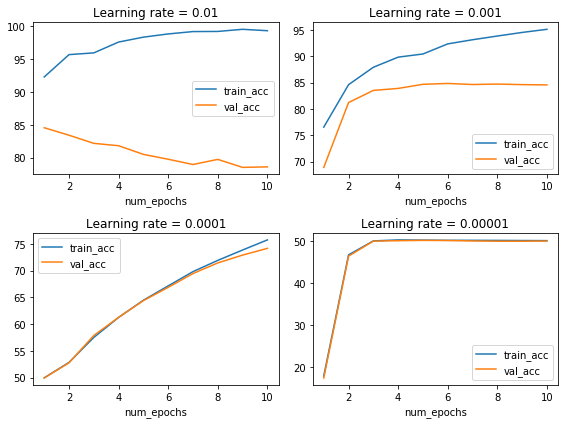

In [113]:
plt.figure(1, figsize=(8,6))
plt.subplot(221)
plt.plot(range(1,11), train_accs_array[1], label='train_acc')
plt.plot(range(1,11), val_accs_array[1], label='val_acc')
plt.title('Learning rate = 0.01')
plt.xlabel('num_epochs')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(range(1,11), train_accs_array[2], label='train_acc')
plt.plot(range(1,11), val_accs_array[2], label='val_acc')
plt.title('Learning rate = 0.001')
plt.xlabel('num_epochs')
plt.legend(loc='best')
plt.subplot(223)
plt.plot(range(1,11), train_accs_array[3], label='train_acc')
plt.plot(range(1,11), val_accs_array[3], label='val_acc')
plt.title('Learning rate = 0.0001')
plt.xlabel('num_epochs')
plt.legend(loc='best')
plt.subplot(224)
plt.plot(range(1,11), train_accs_array[4], label='train_acc')
plt.plot(range(1,11), val_accs_array[4], label='val_acc')
plt.title('Learning rate = 0.00001')
plt.xlabel('num_epochs')
plt.legend(loc='best')
plt.tight_layout()

In [458]:
np.amax(val_accs_array, axis=1)

array([83.14, 84.54, 84.82, 74.14, 50.18])

### 2. Embedding dimensions

In [117]:
learning_rate = 0.001
num_epochs = 10
criterion=torch.nn.CrossEntropyLoss()

In [495]:
emb_dims = [300, 500]
models_emb = []
train_accs_array_emb = np.empty([len(emb_dims), num_epochs])
val_accs_array_emb = np.empty([len(emb_dims), num_epochs])

for i in range(len(emb_dims)):
    model = BagOfWords(len(id2token), emb_dims[i])
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model, train_accs, val_accs = train()
    models_emb.append(model)
    train_accs_array_emb[i]=train_accs
    val_accs_array_emb[i]=val_accs

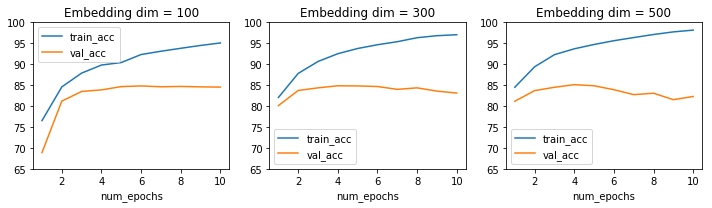

In [137]:
plt.figure(1, figsize=(10,3))
plt.subplot(131)
plt.plot(range(1,11), train_accs_array[2], label='train_acc')
plt.plot(range(1,11), val_accs_array[2], label='val_acc')
plt.title('Embedding dim = 100')
plt.xlabel('num_epochs')
plt.ylim((65,100))
plt.legend(loc='best')
plt.subplot(132)
plt.plot(range(1,11), train_accs_array_emb[0], label='train_acc')
plt.plot(range(1,11), val_accs_array_emb[0], label='val_acc')
plt.title('Embedding dim = 300')
plt.xlabel('num_epochs')
plt.ylim((65,100))
plt.legend(loc='best')
plt.subplot(133)
plt.plot(range(1,11), train_accs_array_emb[1], label='train_acc')
plt.plot(range(1,11), val_accs_array_emb[1], label='val_acc')
plt.title('Embedding dim = 500')
plt.xlabel('num_epochs')
plt.ylim((65,100))
plt.legend(loc='best')
plt.tight_layout()

In [459]:
np.amax(val_accs_array_emb, axis=1)

array([84.86, 85.12])

### 3.Optimizer

In [151]:
learning_rate = 0.001
emb_dim = 500
criterion=torch.nn.CrossEntropyLoss()

In [496]:
model = BagOfWords(len(id2token), emb_dim)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
model_sgd, train_accs_sgd, val_accs_sgd = train()

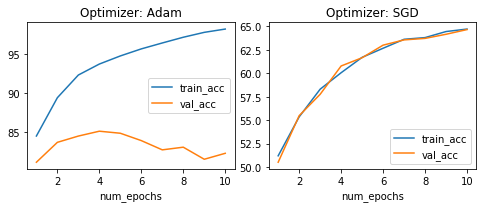

In [140]:
plt.figure(1, figsize=(7,3))
plt.subplot(121)
plt.plot(range(1,11), train_accs_array_emb[1], label='train_acc')
plt.plot(range(1,11), val_accs_array_emb[1], label='val_acc')
plt.title('Optimizer: Adam')
plt.xlabel('num_epochs')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(range(1,11), train_accs_sgd, label='train_acc')
plt.plot(range(1,11), val_accs_sgd, label='val_acc')
plt.title('Optimizer: SGD')
plt.xlabel('num_epochs')
plt.legend(loc='best')
plt.tight_layout()

In [462]:
np.amax(val_accs_sgd)

64.66

### Vocab size

In [214]:
learning_rate = 0.001
emb_dim = 500
criterion=torch.nn.CrossEntropyLoss()

In [497]:
model = BagOfWords(len(id2token), emb_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model_vocab5000, train_accs_vocab5000, val_accs_vocab5000 = train()

In [498]:
model = BagOfWords(len(id2token), emb_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model_vocab20000, train_accs_vocab20000, val_accs_vocab20000 = train()

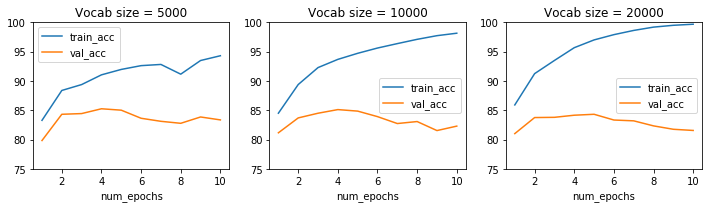

In [220]:
plt.figure(1, figsize=(10,3))
plt.subplot(131)
plt.plot(range(1,11), train_accs_vocab5000, label='train_acc')
plt.plot(range(1,11), val_accs_vocab5000, label='val_acc')
plt.title('Vocab size = 5000')
plt.xlabel('num_epochs')
plt.ylim((75, 100))
plt.legend(loc='best')
plt.subplot(132)
plt.plot(range(1,11), train_accs_array_emb[1], label='train_acc')
plt.plot(range(1,11), val_accs_array_emb[1], label='val_acc')
plt.title('Vocab size = 10000')
plt.xlabel('num_epochs')
plt.ylim((75, 100))
plt.legend(loc='best')
plt.subplot(133)
plt.plot(range(1,11), train_accs_vocab20000, label='train_acc')
plt.plot(range(1,11), val_accs_vocab20000, label='val_acc')
plt.title('Vocab size = 20000')
plt.xlabel('num_epochs')
plt.ylim((75, 100))
plt.legend(loc='best')
plt.tight_layout()

In [221]:
max(val_accs_vocab5000)

85.26

In [463]:
max(val_accs_vocab20000)

84.32

### Tokenization schemes

In [499]:
learning_rate = 0.001
emb_dim = 500
criterion=torch.nn.CrossEntropyLoss()
model = BagOfWords(len(id2token), emb_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model_no_stop, train_accs_no_stop, val_accs_no_stop = train()

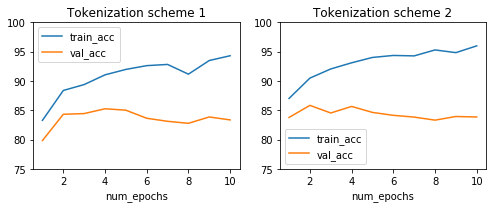

In [270]:
plt.figure(1, figsize=(7,3))
plt.subplot(121)
plt.plot(range(1,11), train_accs_vocab5000, label='train_acc')
plt.plot(range(1,11), val_accs_vocab5000, label='val_acc')
plt.title('Tokenization scheme 1')
plt.xlabel('num_epochs')
plt.ylim((75, 100))
plt.legend(loc='best')
plt.subplot(122)
plt.plot(range(1,11), train_accs_no_stop, label='train_acc')
plt.plot(range(1,11), val_accs_no_stop, label='val_acc')
plt.title('Tokenization scheme 2')
plt.xlabel('num_epochs')
plt.ylim((75, 100))
plt.legend(loc='best')
plt.tight_layout()

In [271]:
max(val_accs_no_stop)

85.84

### n-gram

In [500]:
learning_rate = 0.001
emb_dim = 500
criterion=torch.nn.CrossEntropyLoss()
model = BagOfWords(len(id2token), emb_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model_2gram, train_accs_2gram, val_accs_2gram = train()

In [501]:
model = BagOfWords(len(id2token), emb_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model_3gram, train_accs_3gram, val_accs_3gram = train()

In [502]:
model = BagOfWords(len(id2token), emb_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model_4gram, train_accs_4gram, val_accs_4gram = train()

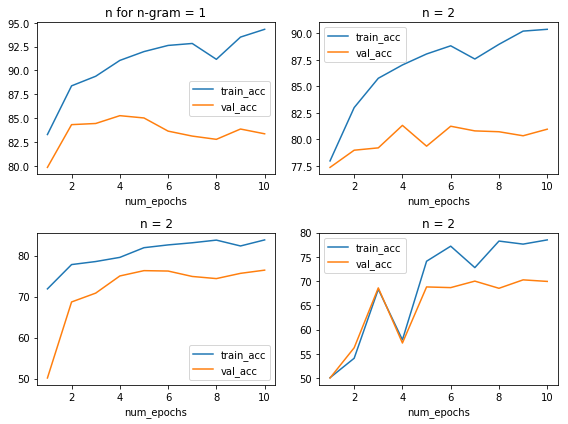

In [449]:
plt.figure(1, figsize=(8,6))
plt.subplot(221)
plt.plot(range(1,11), train_accs_vocab5000, label='train_acc')
plt.plot(range(1,11), val_accs_vocab5000, label='val_acc')
plt.title('n for n-gram = 1')
plt.xlabel('num_epochs')
#plt.ylim((75, 100))
plt.legend(loc='best')
plt.subplot(222)
plt.plot(range(1,11), train_accs_2gram, label='train_acc')
plt.plot(range(1,11), val_accs_2gram, label='val_acc')
plt.title('n = 2')
plt.xlabel('num_epochs')
#plt.ylim((75, 100))
plt.legend(loc='best')
plt.subplot(223)
plt.plot(range(1,11), train_accs_3gram, label='train_acc')
plt.plot(range(1,11), val_accs_3gram, label='val_acc')
plt.title('n = 2')
plt.xlabel('num_epochs')
#plt.ylim((75, 100))
plt.legend(loc='best')
plt.subplot(224)
plt.plot(range(1,11), train_accs_4gram, label='train_acc')
plt.plot(range(1,11), val_accs_4gram, label='val_acc')
plt.title('n = 2')
plt.xlabel('num_epochs')
#plt.ylim((75, 100))
plt.legend(loc='best')
plt.tight_layout()

In [464]:
print(max(val_accs_2gram), max(val_accs_3gram), max(val_accs_4gram))

81.32 76.46 70.26


## Best model performance

In [491]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model_no_stop)))
print ("Test Acc {}".format(test_model(test_loader, model_no_stop)))

After training for 10 epochs
Val Acc 83.74
Test Acc 84.956
